# ДЗ-2 по Теории и практике онлайн экспериментов


Данные лежат на диске: https://disk.yandex.ru/d/9EcCqk-1CUyiCA

### Задание 1 (4 балла)

Представим, что у нас есть сервис для продажи некоторых товаров (например, мыла). Мы выкатываем новые фичи и проводим тесты, а затем сохраняем логи каждого теста в следующем формате:

- `user_id` - уникальный id посетителя сайта
- `dt` - дата события
- `event` - название события
- `group` - группа, в которую попал пользователь (распределение может происходить на разных этапах воронки для разных тестов - например, при первом посещении или при первом добавлении в корзину)
- `visit_id` - уникальный id визита
- `cart_id` - уникальный id корзины
- amount - текущая сумма корзины
- `num_receipt` - текущее количество товаров в корзине


1. Обратимся к метрике **average revenue per paying user**. Вам даны две очень похожие группы (файл `aa_test_logs.pkl`). 

- Постройте распределение p-value для теста на равенство средних между группами.
- Найдите, на каком уровне искусственно добавленного эффекта средняя выручка в группах станет различима. Ошибку первого рода считайте заданной и равной 0.05, ошибку 2-го рода равной 0.2.

In [587]:
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, t
from scipy.stats import kstest, uniform
import numpy as np
import seaborn as sns
from scipy import stats
import sys
import statsmodels.stats.power as smp
from tqdm import tqdm
import pandas as pd
import math
from scipy.stats import pearsonr, spearmanr, kendalltau

In [588]:
data_path = os.path.abspath(r"C:\Users\kuzin\PycharmProjects\MLearning\AB\hw-3")

In [589]:
sys.modules['numpy._core.numeric'] = np.core.numeric
import pickle

C:\Users\kuzin\AppData\Local\Temp\ipykernel_3928\1156640641.py:1: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric.
  sys.modules['numpy._core.numeric'] = np.core.numeric


In [590]:
target = "aa_test_logs.pkl"
path = os.path.join(data_path, target)
with open( os.path.join(data_path,target), 'rb') as f:
    df = pickle.load(f)

In [591]:
#На всякий случай отсортируем таблицу, чтобы корректно заполнить поле  event c card-paid

In [592]:
sorted_df = df.sort_values(['user_id', 'dt', "event"], ascending=[True, True, True])

In [593]:
sorted_df.head(10)

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,user_0,2025-03-06 00:00:00,cart-add,test,visit_1,cart_0,43.22,1.0
1,user_0,2025-03-06 00:01:00,cart-add,test,visit_1,cart_0,97.84,2.0
2,user_0,2025-03-06 00:02:00,cart-add,test,visit_1,cart_0,146.27,7.0
3,user_0,2025-03-06 00:10:00,cart-paid,test,visit_1,cart_0,NaN,NaN
4,user_1,2025-03-11 00:00:00,cart-add,control,visit_2,cart_1,26.08,3.0
5,user_1,2025-03-11 00:01:00,cart-add,control,visit_2,cart_1,34.05,8.0
6,user_1,2025-03-11 00:04:00,cart-add,control,visit_2,cart_1,52.20,17.0
7,user_1,2025-03-11 00:08:00,cart-add,control,visit_2,cart_1,69.51,22.0
8,user_1,2025-03-11 00:09:00,cart-add,control,visit_2,cart_1,93.19,24.0
9,user_1,2025-03-11 00:12:00,cart-add,control,visit_2,cart_1,103.95,30.0


In [594]:
mask = sorted_df["amount"].isna()
prev_val_mask = mask.shift(periods=-1, fill_value=False)
sorted_df.loc[mask,["amount"]] = sorted_df[prev_val_mask]["amount"].values
sorted_df.loc[mask,["num_items"]] = sorted_df[prev_val_mask]["num_items"].values

In [595]:
sorted_df.head(15)

,user_id,dt,event,group,visit_id,cart_id,amount,num_items
0,user_0,2025-03-06 00:00:00,cart-add,test,visit_1,cart_0,43.22,1.0
1,user_0,2025-03-06 00:01:00,cart-add,test,visit_1,cart_0,97.84,2.0
2,user_0,2025-03-06 00:02:00,cart-add,test,visit_1,cart_0,146.27,7.0
3,user_0,2025-03-06 00:10:00,cart-paid,test,visit_1,cart_0,146.27,7.0
4,user_1,2025-03-11 00:00:00,cart-add,control,visit_2,cart_1,26.08,3.0
5,user_1,2025-03-11 00:01:00,cart-add,control,visit_2,cart_1,34.05,8.0
6,user_1,2025-03-11 00:04:00,cart-add,control,visit_2,cart_1,52.20,17.0
7,user_1,2025-03-11 00:08:00,cart-add,control,visit_2,cart_1,69.51,22.0
8,user_1,2025-03-11 00:09:00,cart-add,control,visit_2,cart_1,93.19,24.0
9,user_1,2025-03-11 00:12:00,cart-add,control,visit_2,cart_1,103.95,30.0


In [596]:
pay_users = sorted_df[sorted_df['event'] == "cart-paid"]
t_df = pay_users[pay_users["group"] == "test"]
c_df = pay_users[pay_users["group"] == "control"]

In [597]:
def get_revenue_per_user(df):
    res = df.groupby("user_id")["amount"].sum()
    return res

In [598]:
treat = get_revenue_per_user(t_df).values
control = get_revenue_per_user(c_df).values

In [599]:
treat.shape, control.shape

((1936,), (1939,))

In [600]:
def AA_test(c,t,iter=1000):
    result = []
    for i in range(iter):
        c_boot = np.random.choice(c, len(c), True) # сгенерируем n примеров
        t_boot = np.random.choice(t, len(t), True) # сгенерируем n примеров
        result.append(stats.ttest_ind(c_boot, t_boot, equal_var = False)[1]) # сохраняем pvalue
    plt.hist(result, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()
    result = np.array(result)
    _, p_value = kstest(result, uniform.cdf)

    if p_value > 0.05:
        print("Uniform")  # Sample distribution is likely uniform
    else:
        print("Not Uniform")  # Sample distribution is not likely uniform
    print(f"FPR {sum(np.array(result) < 0.05) / iter}")
    print(f"Control mean {c.mean():.2f}, treat mean {t.mean():.2f}")
    

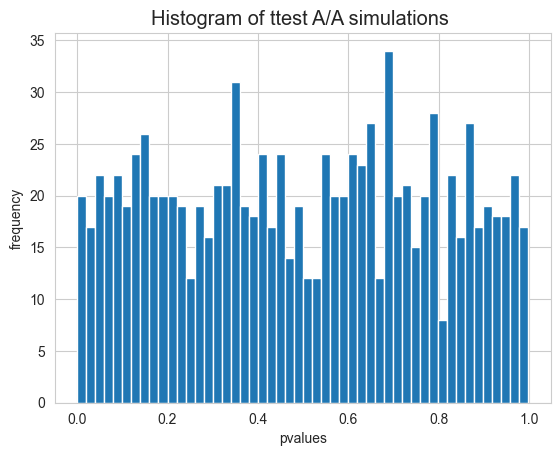

Uniform
FPR 0.048
Control mean 148.16, treat mean 148.62


In [601]:
AA_test(control,treat)

In [602]:
def MDE_find(c,t, n_iter= 1000):
    mean = (c.mean() +  t.mean())/2 
    effects = np.linspace(mean*0.01,mean*0.1, num =  10 )
    effects_stats = []
    for effect in tqdm(effects):
        res  = []
        t_noise = t + np.random.normal(effect, 1, t.shape)
        for i in range(n_iter):
            c_boot = np.random.choice(c, len(c), True)
            t_boot = np.random.choice(t_noise, len(t_noise), True) 
            res.append(stats.ttest_ind(c_boot, t_boot, equal_var = False)[1])
        power = sum(np.array(res) < 0.05) / n_iter
        effects_stats.append(power)
    return effects, np.array(effects_stats)

In [603]:
effect, effect_stats = MDE_find(control,treat,1000)

100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Значение uplift to mean, соответствующее power = 0.8: 12.56462396696356


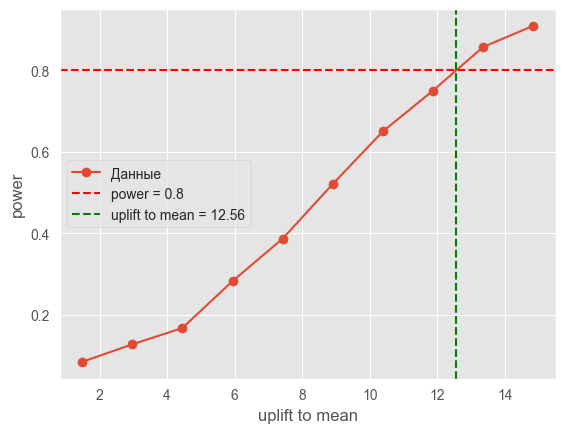

In [604]:
f = interp1d(effect_stats, effect, kind='linear')

# Находим значение x, соответствующее y = 0.8
x_value = f(0.8)
print(f"Значение uplift to mean, соответствующее power = 0.8: {x_value}")

# Визуализация
plt.plot(effect, effect_stats, 'o-', label='Данные')
plt.axhline(y=0.8, color='r', linestyle='--', label='power = 0.8')
plt.axvline(x=x_value, color='g', linestyle='--', label=f'uplift to mean = {x_value:.2f}')
plt.xlabel('uplift to mean')
plt.ylabel('power')
plt.legend()
plt.show()


2. На данных `aa_test_logs.pkl` сравните мощность линеаризации, бутстрапа, бакетизации и дельта-метода для метрики **среднего чека**. Какой метод получился наиболее мощным? Как вы думаете, почему?

In [605]:
def get_data_for_average_receipt(df):
    res = df.groupby("user_id")["amount"].agg(
        amount="sum",
        num = "count"
    ).reset_index(drop=True)
    return res

In [606]:
treat = get_data_for_average_receipt(t_df)
control = get_data_for_average_receipt(c_df)

In [607]:
treat.head(5)

,amount,num
0,146.27,1
1,238.89,1
2,146.09,2
3,53.21,1
4,166.85,2


In [608]:
R_c = control["amount"].sum()/ control["num"].sum()
R_t = treat["amount"].sum()/ treat["num"].sum()
R_c, R_t

(np.float64(101.87012411347517), np.float64(101.24467980295567))

In [609]:
def test_power(control, treat, n_iter = 1000):
    #здесь в трите к сумме заказов для каждого юзера добавим значение, не меняя количество чеков(для простоты)
    alphas = np.linspace(0.05,0.3, num = 6 )
    treat_copy = treat.copy()
    treat_copy["amount"] =  treat["amount"]  +  np.random.normal(10, 1, len(treat))
    stats_power = pd.DataFrame(columns=["linear_proxy", "bootstrap", "delta_method", "bucket_method"], index = alphas)
    for alpha in tqdm(alphas):
        res_bootstrap = []
        res_linearization = []
        res_delta = []
        res_bucket = []
        for i in range(n_iter):
            control_boot  = control.sample(len(control), replace = True)
            treat_boot  = treat_copy.sample(len(treat_copy), replace = True)
            res_linearization.append(linearization_test(control_boot, treat_boot))
            res_delta.append(delta_method(control_boot, treat_boot))
            res_bootstrap.append(bootstrap(control_boot.values, treat_boot.values))
            res_bucket.append(bucket_method(control_boot, treat_boot))
        stats_power.loc[alpha,"linear_proxy"] = sum(np.array(res_linearization) < alpha) / n_iter
        stats_power.loc[alpha,"bootstrap"] = sum(np.array(res_bootstrap) < alpha) / n_iter
        stats_power.loc[alpha,"delta_method"] = sum(np.array(res_delta) < alpha) / n_iter
        stats_power.loc[alpha,"bucket_method"] = sum(np.array(res_bucket) < alpha) / n_iter
    return alphas, stats_power

In [610]:
def linearization_test(control, treat):
    R_c = control["amount"].sum()/ treat["num"].sum()
    control_metric = control.apply(lambda row: row["amount"] - R_c* row["num"], axis =1)
    treat_metric = treat.apply(lambda row: row["amount"] - R_c* row["num"], axis =1)
    return stats.ttest_ind(control_metric, treat_metric, equal_var = False)[1]

In [611]:
def bootstrap(xy_a, xy_b, n_iter=1000):
    """Оценивает значимость отличий с помощью бутстрепа.

    Если отличия значимые, то возвращает 1, иначе 0.
    """
    # генерируем случайные индексы для выбора подмножеств данных
    len_a = len(xy_a)
    len_b = len(xy_b)
    indexes_a = np.random.choice(np.arange(len_a), size=(n_iter, len_a), replace=True)
    indexes_b = np.random.choice(np.arange(len_b), size=(n_iter, len_b), replace=True)

    bootstrap_stats = []
    for idx_a, idx_b in zip(indexes_a, indexes_b):
        bootstrap_xy_a = xy_a[idx_a]
        bootstrap_xy_b = xy_b[idx_b]
        # считаем разницу метрик отношения
        bootstrap_stat = (
            bootstrap_xy_b[:, 0].sum() / bootstrap_xy_b[:, 1].sum()
            - bootstrap_xy_a[:, 0].sum() / bootstrap_xy_a[:, 1].sum()
        )
        bootstrap_stats.append(bootstrap_stat)

    # считаем реальную разность двух групп
    delta_mean = np.sum(xy_b[:, 0]) / np.sum(xy_b[:, 1]) - np.sum(xy_a[:, 0]) / np.sum(
        xy_a[:, 1]
    )
    std_delta_mean = np.std(bootstrap_stats)

    # считаем p-value
    pvalue_delta_mean = 2 * (1 - stats.norm.cdf(np.abs(delta_mean / std_delta_mean)))

    return pvalue_delta_mean

In [612]:
def delta_method(control, treat):
    """Проверка гипотезы с помощью дельта-метода.

    Возвращает p-value.
    """
    dict_ = {}
    for data, group_name in [(control, "a"), (treat, "b")]:
        n_user = len(data)
        mean_x, mean_y = np.mean(data["amount"]), np.mean(data["num"])
        var_x, var_y = np.var(data["amount"]), np.var(data["num"])
        cov_xy = np.cov(data["amount"], data["num"])[0, 1]

        # точечная оценка метрики
        pe_metric = mean_x / mean_y

        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y**2
            - 2 * (mean_x / mean_y**3) * cov_xy
            + var_y * (mean_x**2 / mean_y**4)
        ) / n_user

        dict_[f"pe_metric_{group_name}"] = pe_metric
        dict_[f"var_metric_{group_name}"] = var_metric
    var = dict_["var_metric_a"] + dict_["var_metric_b"]
    delta = dict_["pe_metric_b"] - dict_["pe_metric_a"]
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

In [613]:
def bucket_method(control, treat):
    dict_ = {}
    R_compute = lambda df: df["amount"].sum() / df["num"].sum()
    for data, group_name in [(control, "a"), (treat, "b")]:
        shuffled= data.sample(frac=1, random_state=42).reset_index(drop=True)
        n_user = len(data)
        m = 100
        bucket_metrics = []
        for  i in range(0,n_user, m):
            bucket_metrics.append(R_compute(shuffled[i:i+m]))
        dict_[f"buckets_metric_{group_name}"] = np.array(bucket_metrics)
    return stats.ttest_ind(dict_[f"buckets_metric_a"], dict_[f"buckets_metric_b"]).pvalue

In [614]:
effects, stats_power =  test_power(control, treat,500)

100%|██████████| 6/6 [04:58<00:00, 49.73s/it]


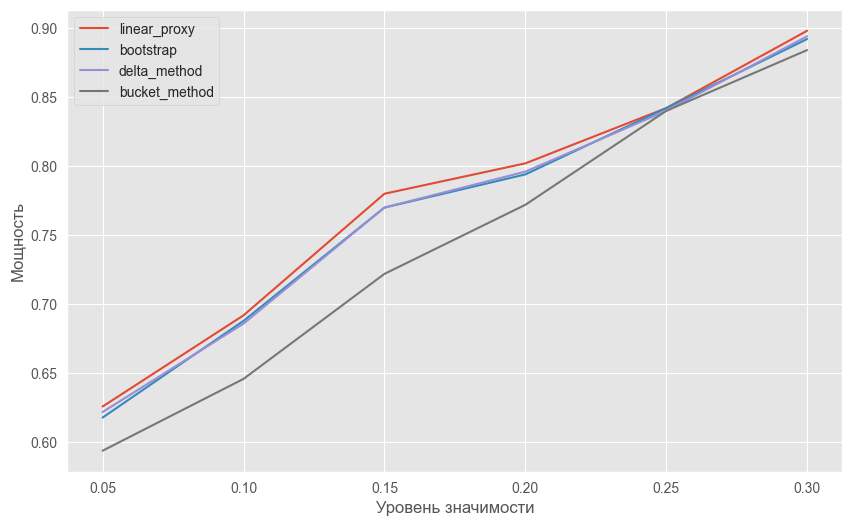

In [615]:
stats_power.plot(figsize=(10, 6))
plt.xlabel("Уровень значимости")
plt.ylabel("Мощность")
plt.show()

Все методы показывают схожие результаты за исключением бакетизации. Бакетизация работает хуже, потому что у нас относительно маленькая выборка, около 2к cэмплов всего, поэтому мы получаем либо мало бакетов, либо мало данных в них, из-за чего усреднённая оценка страдает. И да, линеаризация всё-таки мощнее всех остальных.

3. Мы сделали рекомендательную систему, которая после добавления товара в корзину предлагает добавить похожие или комплементарные. Логи проведенного теста сохранены в файле `ab_test_logs.pkl`. 

- Проверьте гипотезу о том, что это изменение значимо повлияло на ARPPU наших power users (95%-й процентиль).
- Проверьте гипотезу о том, что это изменение значимо повлияло на ARPPU всех юзеров.

In [616]:
target = "ab_test_logs.pkl"
path = os.path.join(data_path, target)
with open( os.path.join(data_path,target), 'rb') as f:
    df_ab = pickle.load(f)

In [617]:
df_ab

,user_id,dt,event,group,visit_id,cart_id,amount,num_items,old_amount
0,user_0,2025-03-06 00:00:00,cart-add,test,visit_1,cart_0,43.22,1.0,43.22
1,user_0,2025-03-06 00:01:00,cart-add,test,visit_1,cart_0,97.84,2.0,97.84
2,user_0,2025-03-06 00:02:00,cart-add,test,visit_1,cart_0,146.27,7.0,146.27
3,user_0,2025-03-06 00:10:00,cart-paid,test,visit_1,cart_0,NaN,NaN,NaN
4,user_1,2025-03-11 00:00:00,cart-add,control,visit_2,cart_1,26.08,3.0,26.08
...,...,...,...,...,...,...,...,...,...
31520,user_998,2025-03-03 00:13:00,cart-paid,control,visit_1482,cart_1455,NaN,NaN,NaN
31521,user_999,2025-03-19 00:00:00,cart-add,test,visit_1483,cart_1456,20.60,4.0,20.60
31522,user_999,2025-03-19 00:04:00,cart-add,test,visit_1483,cart_1456,44.49,12.0,44.49
31523,user_999,2025-03-19 00:06:00,cart-add,test,visit_1483,cart_1456,54.66,16.0,54.66


In [618]:
sorted_df = df_ab.sort_values(['user_id', 'dt', "event"], ascending=[True, True, True])
sorted_df.head(10)
mask = sorted_df["amount"].isna()
prev_val_mask = mask.shift(periods=-1, fill_value=False)
sorted_df.loc[mask, ["amount"]] = sorted_df[prev_val_mask]["amount"].values
sorted_df.loc[mask, ["num_items"]] = sorted_df[prev_val_mask]["num_items"].values
pay_users = sorted_df[sorted_df['event'] == "cart-paid"]
t_df = pay_users[pay_users["group"] == "test"]
c_df = pay_users[pay_users["group"] == "control"]
treat = get_revenue_per_user(t_df).values
control = get_revenue_per_user(c_df).values

In [619]:
treat.mean(), control.mean()

(np.float64(155.27592794116856), np.float64(148.1556214543579))

In [620]:
bootstrap_vol=10000
quantile_of_interest = .95
alpha = .05

Там далее будет перебор для разных квантилей, поэтому был выбран более быстрый вариант бутстрапа,чтобы не ждать полчаса. Он даёт очень схожие результаты с классическим, хотя и имеет чуть более консервативные оценки
[Bootstrap spotify](https://engineering.atspotify.com/2022/03/comparing-quantiles-at-scale-in-online-a-b-testing/)

In [621]:
def rnd_spotify_bootstrap(control,treat,bootstrap_vol,quantile_of_interest,alpha):
    control_sample_sorted = np.sort(control)
    treatment_sample_sorted = np.sort(treat)
    spotify_bootstrap_difference = control_sample_sorted[np.random.binomial(len(control)+1, quantile_of_interest,
    bootstrap_vol)] - treatment_sample_sorted[np.random.binomial(len(treat)+1,
                            quantile_of_interest, bootstrap_vol)]
    
    diff_quantile = np.quantile(control_sample_sorted, quantile_of_interest) - np.quantile(treatment_sample_sorted, quantile_of_interest)
    spotify_confidence_interval = np.quantile(spotify_bootstrap_difference,
    [alpha/2 , 1-alpha/2])
    return diff_quantile, spotify_confidence_interval

In [622]:
diff_quantile, spotify_confidence_interval = rnd_spotify_bootstrap(control,treat,bootstrap_vol,quantile_of_interest,alpha)
print(f"The {(1-alpha)*100}% confidence interval is given by ({spotify_confidence_interval}) for quantile: {quantile_of_interest:.2f} \nEstimated diff quantile: {diff_quantile:.2f}")

The 95.0% confidence interval is given by ([-139.31014262  -35.82463944]) for quantile: 0.95 
Estimated diff quantile: -75.27


Для 95-квантиля видим, что он действительно вырос в трите и это изменение статзначимое, так как  доверительный интервал  не захватывает ноль.

Чтобы проверить, как рекомендательная система отразилась для других юзеров, попробуем перебрать квантили, до тех пор, пока не найдём ненулевую стат.значимую разность.

In [623]:
for quantile in np.linspace(.1, .95, 10):
    _, lr = rnd_spotify_bootstrap(control,treat,bootstrap_vol,quantile,alpha)
    if  lr[0] >= 0 or 0  >=lr[1]:
        print(f"quantile valuable diff  {quantile:.2f}")

quantile valuable diff  0.95


Разность начинается с 95-квантиля, это значит рекомендательная система  не ухудшает пользовательский опыт для обычных и нелояльных юзеров, но хорошо работает на power-юзерах

### Задание 2 (1 балл)

В приложенном файле `sleep.csv` приведено время засыпания одного и того же человека в разные дни.

Нужно обработать эти данные и указать такое время суток (с точностью до минуты), после которого с вероятностью 0.9 этот человек уже спит.

Как можно оценить стандартное отклонение этой точечной оценки?

In [624]:
target = "sleep.csv"
path = os.path.join(data_path, target)
df = pd.read_csv(path)

In [625]:
df.rename(columns={df.columns[0]: "tstamp"}, inplace=True)
df.tstamp = pd.to_datetime(df.tstamp)
df["time_only"] = df["tstamp"].dt.time
time_offset_0 = pd.to_datetime("22:00:00").time()
#проверим, всегда ли офсет отсчитывается от "22:00:00"
res = df[df.time_offset ==0]
mask = res["time_only"] != time_offset_0
filtered_df = res[mask]
filtered_df

,tstamp,indicator,time_offset,time_only


In [626]:
# Находим строки, где значение меняется с 0 на 1
df["is_first_one"] = (df["indicator"] == 1) & (df["indicator"].shift(1) == 0)
first_ones_df = df[df["is_first_one"]]
first_sleep = first_ones_df["time_offset"].values

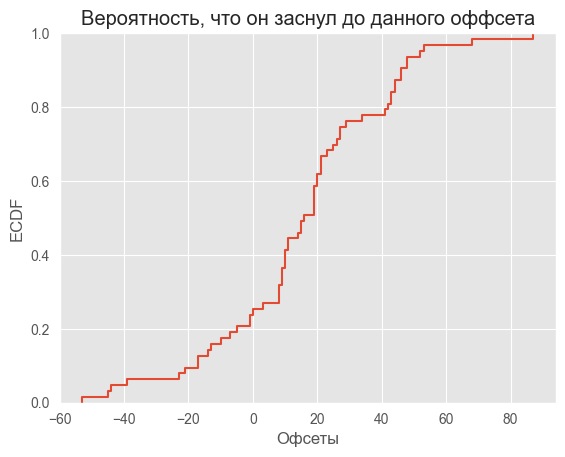

In [627]:
sns.ecdfplot(first_sleep)
plt.xlabel("Офсеты")
plt.ylabel("ECDF")
plt.title("Вероятность, что он заснул до данного оффсета")
plt.grid(True)
plt.show()

Можно было бы срезать датасет по всем единичным индикаторам, построить распределение на них, но тогда точечная оценка того, что человек спит в данный момент времени t, будет суммой вероятностей, что он одновременно заснул во все моменты до момента t, а это не очень правильно.

Данных не так много, но всё равно попробуем забутстрапить, построить распределение на 90-квантиль и посчитать дисперсию.

In [628]:
#здесь будем использовать классический бустрап, так как данных мало
def bootstrap_quantiles(values, n_iter=10000):
    boot = np.random.choice(values, size=(n_iter,len(values)), replace=True)
    std_ = np.std(np.quantile(boot, .90, axis=1))
    return std_

In [629]:
std_ = bootstrap_quantiles(first_sleep)
std_

np.float64(3.2523849590108505)

In [630]:
np.quantile(first_sleep, .90)

np.float64(46.0)

### Положительный офсет это одна минута к 22-часам. Тогда ответ 22:46:00 +- 3 min

### Задание 3. CUPED (1 балла)

Cгенерируем выборку из $1000$ сэмплов экспоненциального распределения - это будут значения нашей метрики для $1000$ пользователей

In [631]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

In [632]:
control_before = stats.expon(scale=1000).rvs(1000)

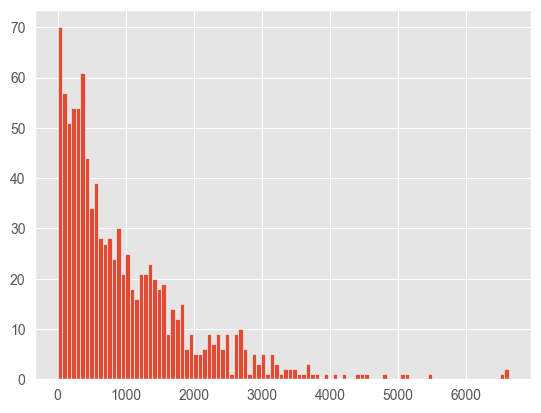

In [633]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [634]:
control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

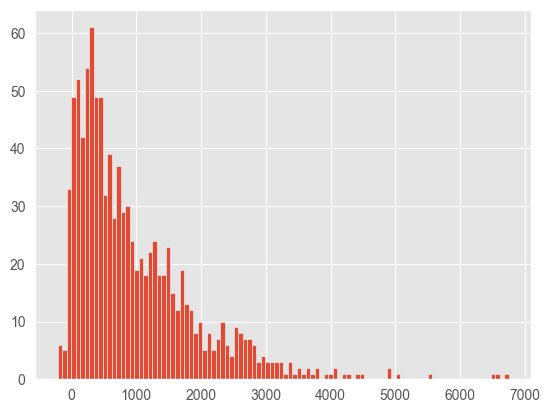

In [635]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$ раз

In [636]:
stats.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf(
    [0.025, 0.975]
)

array([ 918.61787399, 1038.35357615])

In [637]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)
    left_bound, right_bound = stats.norm(
        loc=control.mean(), scale=control.std() / np.sqrt(len(control))
    ).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

100%|██████████| 10000/10000 [00:14<00:00, 695.00it/s]

Стат значимая разница есть в 4.79% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

In [638]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)
    
    theta = np.cov(control, control_before, bias=True)[0, 1]/np.var(control_before)
    #print(theta)
    mean = np.mean(control) -  np.mean(control_before)* theta
    std = np.sqrt((np.var(control) - 2*theta* np.cov(control, control_before, bias=True)[0, 1] 
           + theta**2 * np.var(control_before))/len(control))
    left_bound, right_bound = stats.norm(loc=mean, scale=std).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

100%|██████████| 10000/10000 [00:15<00:00, 655.65it/s]

Стат значимая разница есть в  100.0% случаев;


По всей видимости тут есть ошибка в проверке, так как границы уже не следует сравнивать с 1000

Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом приме
ре с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [639]:
bad_cnt = 0
bad_cnt_after = 0
bad_cnt_before = 0
N = 1000
for i in tqdm(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_before_merged = np.hstack((control_before_a, control_before_b)) #наши ковариаты
    control_after_merged = np.hstack((control_after_a, control_after_b)) #типо 
    theta = np.cov(control_after_merged, control_before_merged, bias=True)[0, 1]/np.var(control_before_merged)
    control_cup_a = control_after_a - theta*control_before_a
    control_cup_b = control_after_b - theta*control_before_b

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1
    if stats.kstest(control_after_a, control_after_b).pvalue < 0.05:
        bad_cnt_after += 1
    if stats.kstest(control_before_a, control_before_b).pvalue < 0.05:
        bad_cnt_before += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")
print(f"Стат значимая разница есть в  {round(bad_cnt_after / N, 4) * 100}% случаев;")

100%|██████████| 1000/1000 [00:08<00:00, 117.48it/s]

Стат значимая разница есть в  4.9% случаев;
Стат значимая разница есть в  4.3% случаев;
Стат значимая разница есть в  4.9% случаев;


Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:



Я так понимаю нужно сравнить это с вышестоящим заданием, но кажется там сама проверка некорректная. Что касается этого задания, то здесь купед отпилит дисперсию шума, которая составляет 10_000 по сравнению с дисперсией в один миллион основной выборки. Это надбавка шума всё равно будет относительно маленькой, поэтому КС тест считает, что распределения всё равно одинаковые.

Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [ ]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 1000
for i in tqdm(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=10, scale=100).rvs(
        samples_in_ab // 2
    )
    
    control_before_merged = np.hstack((control_before_a, control_before_b)) 
    control_after_merged = np.hstack((control_after_a, control_after_b)) 
    theta = np.cov(control_after_merged, control_before_merged, bias=True)[0, 1]/np.var(control_before_merged)
    control_cup_a = control_after_a - theta*control_before_a
    control_cup_b = control_after_b - theta*control_before_b


    if stats.kstest(control_after_a, control_after_b).pvalue < 0.05:
        bad_cnt += 1

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt_cuped += 1

print(
    f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев; при использовании CUPED -- в {round(bad_cnt_cuped / N, 4) * 100}% случаев"
)

### Задание 4. Методы снижения дисперсии (2 балла)

В этой части задания вам нужно применить методы снижения дисперсии с лекций, чтобы провести более точные тесты по данным из файла.

Данные представляют собой значение какой-то метрики для трех возрастных групп пользователей. Столбец group отвечает за группу, в которой находятся пользователи: 
- `None` - пользователь не участвует в АБ тесте, 
- `*_before_i` - соответствующая группа до начала теста, 
- `*_after_i` - группа после начала эксперимента

Чем больше i, тем позже было сделано наблюдение. 

Cчитайте, что юзеры всегда идут в одном порядке в группах. То есть `data[data.group == 'control_before_i']`
дает юзеров в той же последовательности, что `data[data.group == 'control_after_i']` для всех i.  Аналогичное верно для тритмента.


#### Что надо сделать:
1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

2. Реализуйте пост-стратификацию и CUPED. 

3. Проведите тесты между `control_before_i` и `treatment_before_i` снчала без применения пост-стратификации и CUPED, а затем с ними. Без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие на уровне значимости $0.05$

4. Опишите свои результаты.

In [641]:
def t_test(sample1, sample2):
    mean1 = sum(sample1) / len(sample1)
    mean2 = sum(sample2) / len(sample2)
    var1 = sum((x - mean1) ** 2 for x in sample1) / (len(sample1) - 1)
    var2 = sum((x - mean2) ** 2 for x in sample2) / (len(sample2) - 1)
    n1 = len(sample1)
    n2 = len(sample2)
    t_stat = (mean1 - mean2) / math.sqrt(var1 / n1 + var2 / n2)
    df = n1 + n2 - 2
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    return t_stat, p_value

In [642]:
target = "data_ab.csv"
path = os.path.join(data_path, target)
df = pd.read_csv(path)

In [643]:
df

,age,metric,group
0,young,11309.036916,treatment_before
1,young,8496.554679,control_before
2,young,11891.862586,control_before
3,young,9229.445011,treatment_before
4,young,10410.961279,control_before
...,...,...,...
99995,old,7890.224384,treatment_after_5
99996,old,8165.046263,treatment_after_5
99997,old,10034.632118,treatment_after_5
99998,old,7564.445251,treatment_after_5


treatment_before_i нету, все группы одинакого размера

In [644]:
df.groupby("group").size()

group
control_after_1      4500
control_after_2      4500
control_after_3      4500
control_after_4      4500
control_after_5      4500
control_before       4500
treatment_after_1    4500
treatment_after_2    4500
treatment_after_3    4500
treatment_after_4    4500
treatment_after_5    4500
treatment_before     4500
dtype: int64

In [645]:
df.group.unique(), len(df)

(array(['treatment_before', 'control_before', nan, 'control_after_1',
        'treatment_after_1', 'control_after_2', 'treatment_after_2',
        'control_after_3', 'treatment_after_3', 'control_after_4',
        'treatment_after_4', 'control_after_5', 'treatment_after_5'],
       dtype=object),
 100000)

In [646]:
p_k = df.groupby("age").size() / len(df)
p_k

age
adult    0.45
old      0.35
young    0.20
dtype: float64

In [647]:
def compute_strata_info(alias, df,p_k):
    privot_strats = df[df.group == alias].groupby('age')["metric"].agg(
        avg_ = "mean",
        var_ = "var" 
    )
    n_vol = len(df[df.group == alias])
    mean_strat = sum(privot_strats.avg_ * p_k.values)
    var_strat = sum((privot_strats.var_ * p_k.values))/n_vol + sum((1-p_k.values)*privot_strats.var_)/n_vol**2
    return mean_strat, var_strat, n_vol

In [648]:
def post_strats(control_alias,treat_alias,df, p_k: pd.DataFrame):
    control_mean, control_var, n_c =  compute_strata_info(control_alias,df,p_k)
    treat_mean, treat_var, n_t =  compute_strata_info(treat_alias,df,p_k)
    std_all = np.sqrt(treat_var + control_var)
    order_stud = (treat_var + control_var)**2/(treat_var**2/(n_t - 3) + control_var**2/(n_c - 3))
    t_stat = (control_mean - treat_mean)/std_all
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), order_stud))
    return t_stat, p_value

In [649]:
def cuped(control_alias, treat_alias, df): 
    control_before = df[df.group == "control_before"].metric.values
    treat_before = df[df.group == "treatment_before"].metric.values
    covariates = np.hstack((control_before, treat_before))
    control = df[df.group == control_alias].metric.values
    treat = df[df.group == treat_alias].metric.values
    metric = np.hstack((control, treat))
    theta = np.cov(covariates, metric, bias=True)[0, 1]/np.var(covariates)
    control_cuped = control - theta*control_before
    treat_cuped = treat - theta*treat_before
    return t_test(control_cuped, treat_cuped)

In [650]:
pivot = pd.DataFrame(index = list(range(1,6)), columns=["t_test", "cuped", "post_strat"])


for i in range(1,6):
    control_alias = f"control_after_{i}"
    treatment_alias = f"treatment_after_{i}"
    control  = df[df.group == control_alias].metric.values
    treat  = df[df.group == treatment_alias].metric.values
    _, p_value = t_test(control, treat)
    pivot.loc[i, "t_test"] = p_value
    _, p_value= cuped(control_alias, treatment_alias, df)
    pivot.loc[i, "cuped"] = p_value
    _, p_value= post_strats(control_alias, treatment_alias, df,p_k)
    pivot.loc[i, "post_strat"] = p_value

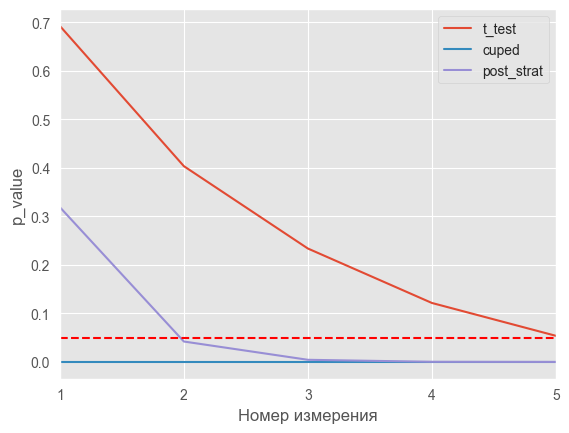

In [651]:
pivot.plot()
plt.xlim([1,5])
plt.xticks(range(1, 6)) 
plt.xlabel("Номер измерения")
plt.ylabel("p_value")
plt.axhline(y = 0.05, color="r", linestyle='--', label='alpha 0.05')
plt.show()

CUPED начал видеть различия с самого начала, пост-стратификация начиная со второго отсчёта, а обычный t-test только на 5-ом измерении подошёл к уровню значимости.

### Задание 5. Линеаризация + CUPED (2.5 балла)

1. В файле `duration_aa.csv` содержатся данные для АА-теста. Проверьте гипотезу о равенстве средних длительностей визита с помощью линеаризации, постройте распределение p-value.

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле `duration_ab.csv`. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

В каждом пункте необходимо визуализировать распределение p-value и сонаправленность линеаризованной разности метрик и разности ratio-метр ик.

In [652]:
target = "duration_aa.csv"
df = pd.read_csv(os.path.join(data_path, target))
df.head(5)

,Unnamed: 0,user_id,group,visit_id,visit_duration
0,0,JP1F82,first,ypn3ydiml32oelnslnjv,84.0
1,1,JP1F82,first,ypy93q2g8ypdtwbpv8b5,61.0
2,2,JP1F82,first,d8m6q0bmr40wgi6zuor3,81.0
3,3,JP1F82,first,5b72re4nr84fszqx7f6e,54.0
4,4,0Y2HSZ,first,z40pmuyaczi92gmlqz6t,97.0


In [653]:
def prepare_data(df, control_alias, treat_alias):
    res = df.groupby(["user_id", "group"])["visit_duration"].agg(
    amount = "sum",
    num = "count"
    ).reset_index()
    treat = res[res.group == treat_alias]
    treat.set_index("user_id", inplace = True)
    control = res[res.group == control_alias]
    control.set_index("user_id", inplace = True)
    return control, treat

In [654]:
control, treat = prepare_data(df, "first", "second")

In [655]:
def linearization_test_duration(control, treat):
    R_c = control["amount"].sum()/ control["num"].sum()
    R_t = treat["amount"].sum()/ treat["num"].sum()
    control_metric = control.apply(lambda row: row["amount"] - R_c* row["num"], axis =1)
    treat_metric = treat.apply(lambda row: row["amount"] - R_c* row["num"], axis =1)
    return (control_metric.mean() - treat_metric.mean(),
            R_c - R_t,
            stats.ttest_ind(control_metric, treat_metric, equal_var = False)[1])

In [656]:
def Ratio_test(control, treat, n_iter = 1000):
    alpha = .05
    p_values = []
    diff = []
    for i in tqdm(range(n_iter)):
        control_boot  = control.sample(len(control), replace = True)
        treat_boot  = treat.sample(len(treat), replace = True)
        proxy_diff, ratio_diff, p_value = linearization_test_duration(control_boot, treat_boot)
        diff.append((proxy_diff, ratio_diff))
        p_values.append(p_value)
    fpr = sum(np.array(p_values) < alpha) / n_iter
    diff = np.array(diff)
    return p_values, diff, fpr

In [657]:
p_values, diff,  fpr = Ratio_test(control,treat)

100%|██████████| 1000/1000 [00:11<00:00, 85.96it/s]


In [658]:
def show_res(p_values, diff):
    plt.figure(figsize=(10, 6))
    plt.subplot(1,2,1)
    sns.ecdfplot(p_values)
    plt.plot([0, 1], [0, 1], "--k", alpha=0.8)
    plt.xlabel("p_values")
    plt.subplot(1,2,2)
    plt.scatter(diff[:,0], diff[:,1], s=1)
    plt.xlabel("Ratio delta")
    plt.ylabel("Proxy delta")

### AA_test

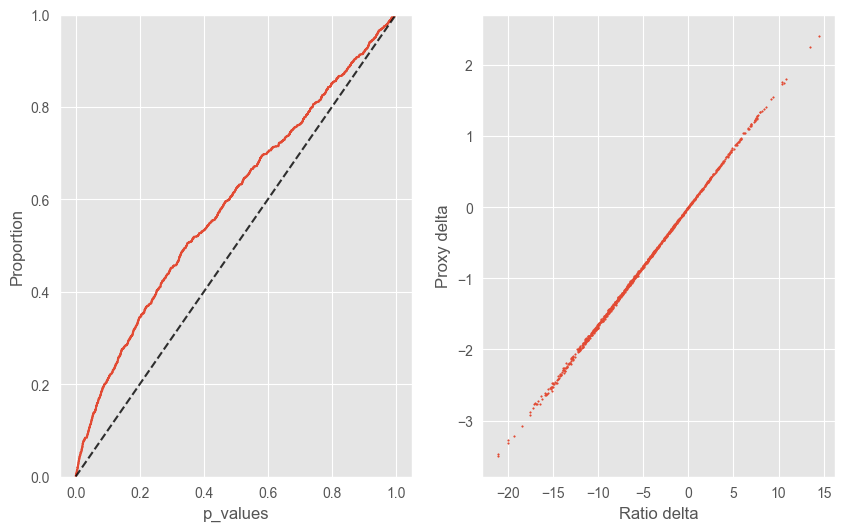

In [659]:
show_res(p_values, diff)

In [660]:
np.quantile(p_values, .05)

np.float64(0.015155685887397897)

In [661]:
target = "duration_ab.csv"
df = pd.read_csv(os.path.join(data_path, target))
target = "duration_hist.csv"
df_cuped = pd.read_csv(os.path.join(data_path, target))
control, treat = prepare_data(df, "a", "b")

#### AB_test

100%|██████████| 1000/1000 [00:11<00:00, 85.14it/s]


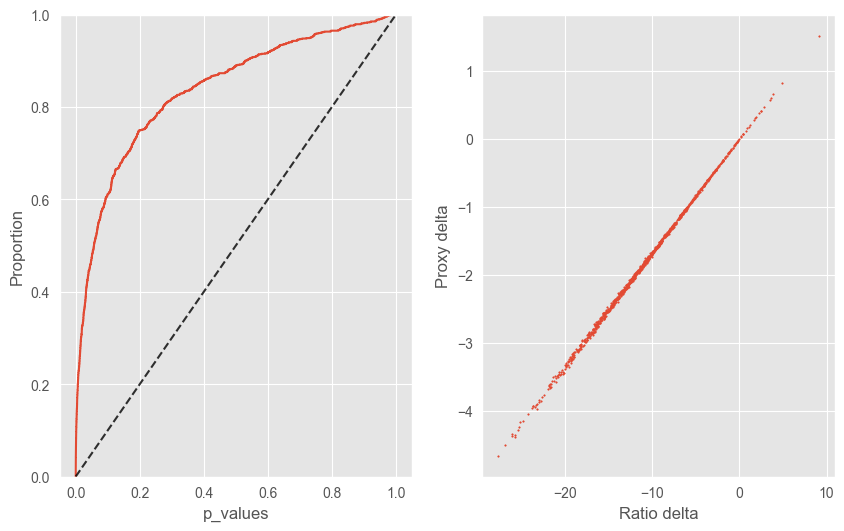

In [662]:
p_values, diff,  fpr = Ratio_test(control,treat)
show_res(p_values, diff)

In [663]:
agg_full = df_cuped.groupby(["user_id"])["visit_duration"].agg(
amount = "sum",
num = "count"
).reset_index()

In [665]:
# посчитаем по всем, чтобы уточнить оценку, так как данных на экспе мало
R_c_full = sum(agg_full.amount.values) / sum(agg_full.num.values) 

In [666]:
get_proxy = lambda df, R_c: df.apply(lambda row: row["amount"] - R_c* row["num"], axis =1)

In [667]:
# Здесь с таким же смыслом
Var_full = np.var(get_proxy(agg_full,R_c_full))

In [668]:
def Ratio_test_cuped(control, treat, n_iter = 1000):
    alpha = .05
    p_values = []
    diff = []
    rhos = []
    get_history_covariate = lambda indexes:df_cuped[df_cuped.user_id.isin(indexes)].groupby(["user_id"])["visit_duration"].agg(
        amount = "sum",
        num = "count"
    ).reset_index()
    get_proxy = lambda df, R_c: df.apply(lambda row: row["amount"] - R_c* row["num"], axis =1)
    get_r  = lambda df:  df["amount"].sum()/ df["num"].sum()
    covariate_control_df = get_history_covariate(control.index.values)
    covariate_control_df.set_index("user_id", inplace=True)
    covariate_treat_df = get_history_covariate(treat.index.values)
    covariate_treat_df.set_index("user_id", inplace=True)
    for i in tqdm(range(n_iter)):
        control_boot  = control.sample(len(control), replace = True)
        covariate_control_df_boot =covariate_control_df.loc[control_boot.index]
        #проверка на то, что вовзращает  объект к объекту, чтобы корреляцию посчитать норм
        #print(list(zip(list(control_boot.index),list(covariate_control_df_boot.index))))
        treat_boot  = treat.sample(len(treat), replace = True)
        covariate_treat_df_boot = covariate_treat_df.loc[treat_boot.index]
        R_c_after = get_r(control_boot)
        R_t_after = get_r(treat_boot)
        control_metric_after = get_proxy(control_boot, R_c_after)
        treat_metric_after = get_proxy(treat_boot, R_c_after)
        control_metric_before = get_proxy(covariate_control_df_boot, R_c_full)
        treat_metric_before = get_proxy(covariate_treat_df_boot, R_c_full)
        metric_before_merged = np.hstack((control_metric_before, treat_metric_before))
        metric_after_merged = np.hstack((control_metric_after, treat_metric_after)) 
        theta = np.cov(metric_after_merged, metric_before_merged, bias=True)[0, 1]/Var_full
        control_cuped = control_metric_after - theta*control_metric_before
        treat_cuped = treat_metric_after - theta*treat_metric_before
        #cобираем статистики
        corr_pearson, _ = pearsonr(metric_after_merged, metric_before_merged)
        rhos.append(corr_pearson)
        diff.append((control_cuped.mean()  -treat_cuped.mean(),R_c_after - R_t_after ))
        p_values.append(stats.ttest_ind(control_cuped, treat_cuped, equal_var = False)[1])
    return p_values, np.array(diff), rhos

In [669]:
p_values_cuped,diff, rhos  = Ratio_test_cuped(control,treat, 1000)

100%|██████████| 1000/1000 [00:24<00:00, 41.08it/s]


#### CUPED

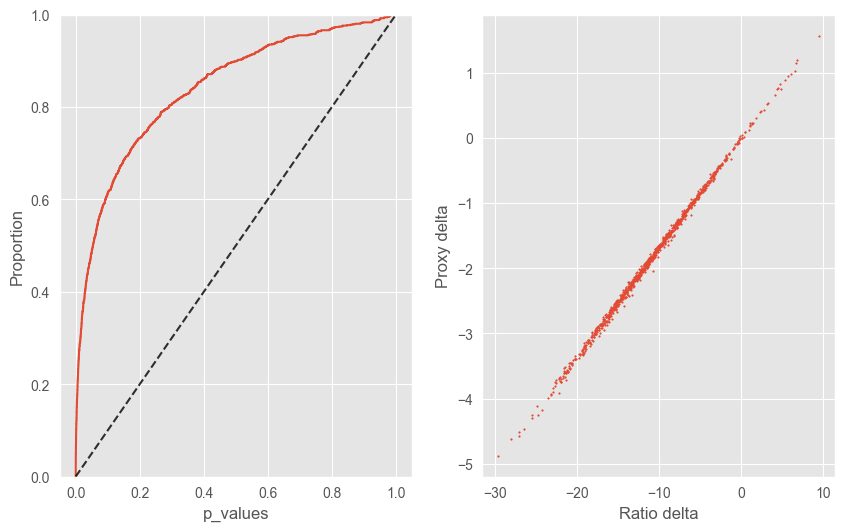

In [670]:
show_res(p_values_cuped, diff)

#### Сравнение t-test'a VS линеаризации + CUPED  

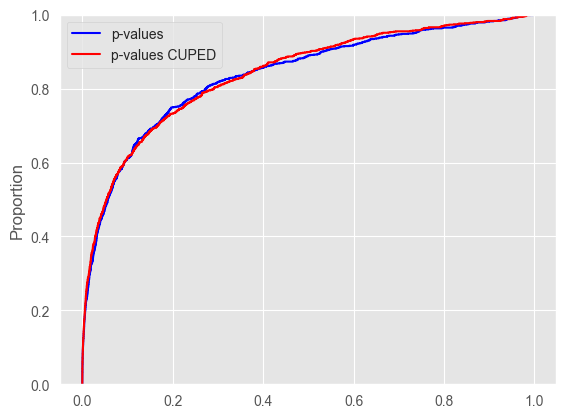

In [671]:
sns.ecdfplot(p_values, color='blue', label='p-values')
sns.ecdfplot(p_values_cuped, color='red', label='p-values CUPED')
plt.legend()

Видим, что значимого улчушения от купеда мы не получили. Попробуем проверить коэффицент корреляции между ковариатой и таргетом

### Посмотрим на значения корреляции между историческими данными и метрикой на экспе. 

<Axes: ylabel='Count'>

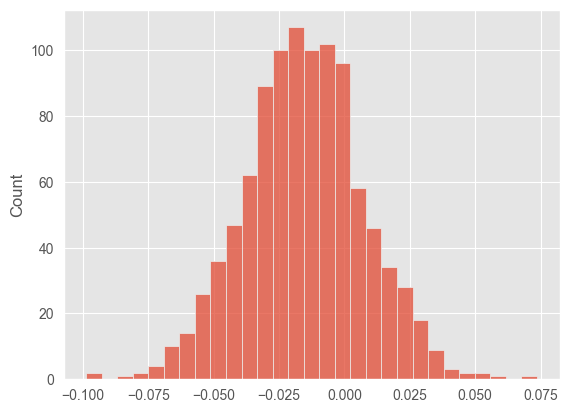

In [672]:
sns.histplot(rhos)

Корреляция отсутсвует, поэтому в большинстве случаев мы не получили редукции дисперсии, а это значит, что не выиграли в чувствительности, и соответсвенно не получили улучушения от купеда.